In [1]:
%load_ext autoreload
%autoreload 2

## Partie 2

### Visualisation de l'algorithme de recherche local pour 100 objets et 3 critères (sur les 2 premiers critères)

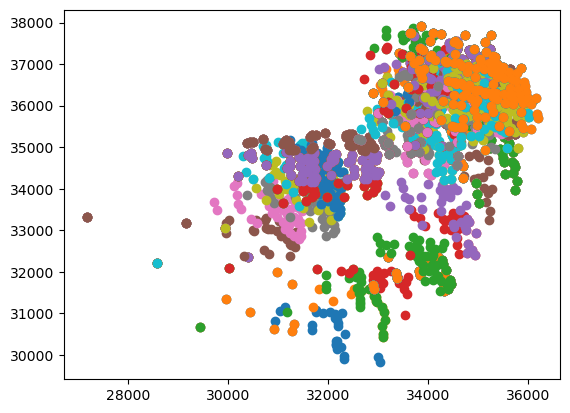

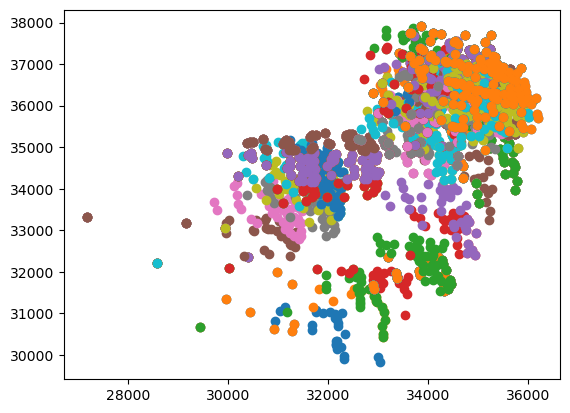

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ndtree import *
from pareto import *
from func import *
from voisinage import *
from paretolocalsearch import *
from gurobi import *

w=np.zeros(200,dtype=int)
v=np.zeros((200,6),dtype=int)
filename = "data/2KP200-TA-0.dat"
W=readFile(filename,w,v)

#Génération de m solutions aléatoires
m=1000

N_OBJETS = 100
N_CRITERES = 3

#Reshape v and w to only take first three objectives and first 20 items
v = v[:N_OBJETS]
v = v[:,:N_CRITERES]
w = w[:N_OBJETS]

#W equals the sum of the weights divided by 2
W = int(w.sum()/2)

costs = {}
solutions = {}

for i in range(m):
	w_total = 0
	current_solution = set()
	current_cost =  np.zeros(v.shape[1])
	arr = np.arange(w.shape[0])
	np.random.shuffle(arr)
	for j in arr:
		if w_total + w[j] <= W:
			current_solution.add(j)
			next_item = v[j]
			w_total += w[j]
			for k in range(v.shape[1]):
				current_cost[k] += next_item[k]
	costs[i] = current_cost
	solutions[i] = current_solution

pls = PLS(costs, solutions, v, w, W, do_display=True)

### Chargement des données

In [84]:
#Chargement des données pour chaque fonction d'aggrégation
import os

dirpath = "./logs/process1/"
files = os.listdir(dirpath)

ws_data = []
owa_data = []
choquet_data = []

for file in files:
    df = pd.read_csv(dirpath+file)
    if "WS" in file:
        ws_data.append(df)
    elif "OWA" in file:
        owa_data.append(df)
    if "Choquet" in file:
        choquet_data.append(df)

all_data_1 = [ws_data, owa_data, choquet_data]

### Etude du nombre de questions selon la fonction d'aggrégation

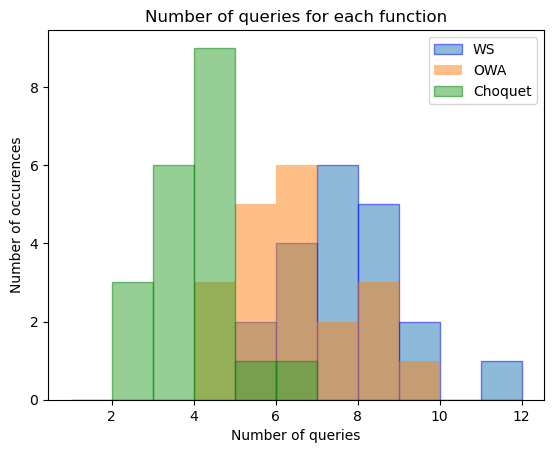

Nombres de questions moyens pour WS : 7.25, médiane : 7.0, écart-type : 1.4097872179871684
Nombres de questions moyens pour OWA : 6.0, médiane : 6.0, écart-type : 1.4142135623730951
Nombres de questions moyens pour Choquet : 3.55, médiane : 4.0, écart-type : 0.9733961166965892


In [85]:
all_queries_ws = [d.tail(1)["Query"]+1 for d in ws_data]
all_queries_owa = [d.tail(1)["Query"]+1 for d in owa_data]
all_queries_choquet = [d.tail(1)["Query"]+1 for d in choquet_data]

all_queries_ws = np.array(all_queries_ws).flatten()
all_queries_owa = np.array(all_queries_owa).flatten()
all_queries_choquet = np.array(all_queries_choquet).flatten()

bins = np.linspace(1, 12, 12)

#Plotting histograms with the number of queries for each function on the same figure
plt.hist(all_queries_ws, bins, edgecolor="blue", alpha = 0.5, label="WS")
plt.hist(all_queries_owa, bins, alpha = 0.5, label="OWA")
plt.hist(all_queries_choquet, bins, edgecolor="green", alpha = 0.5, label="Choquet")
plt.legend(loc='upper right')
plt.title("Number of queries for each function")
plt.xlabel("Number of queries")
plt.ylabel("Number of occurences")
plt.show()

print("Nombres de questions moyens pour WS : " + str(np.mean(all_queries_ws)) + ", médiane : " + str(np.median(all_queries_ws)) + ", écart-type : " + str(np.std(all_queries_ws)))
print("Nombres de questions moyens pour OWA : " + str(np.mean(all_queries_owa)) + ", médiane : " + str(np.median(all_queries_owa)) + ", écart-type : " + str(np.std(all_queries_owa)))
print("Nombres de questions moyens pour Choquet : " + str(np.mean(all_queries_choquet)) + ", médiane : " + str(np.median(all_queries_choquet)) + ", écart-type : " + str(np.std(all_queries_choquet)))

### Etude de la variation du regret minimax en fonction du nombre de questions posées pour les fonction d'aggrégation

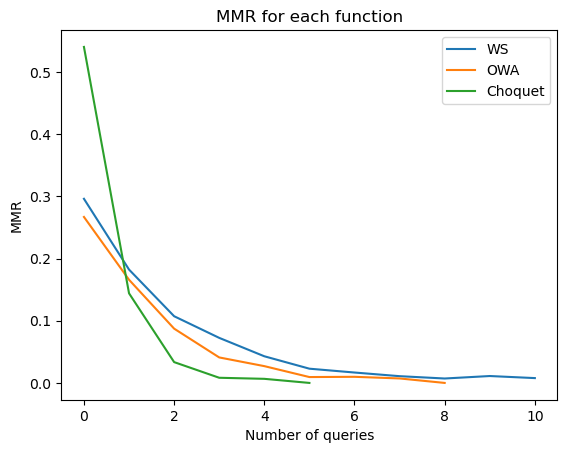

In [86]:
func_names = ["WS", "OWA", "Choquet"]
ind = 0
for data in all_data_1:
    mmr = [d["MMR"] for d in data]
    max_len = max([len(d.index) for d in mmr])
    mmr_n_queries = np.zeros(max_len)
    mmr_total_queries = np.zeros(max_len)
    for d in mmr:
        for i in range(len(d)):
            mmr_n_queries[i] += 1
            mmr_total_queries[i] += d[i]
    plot_mmr = mmr_total_queries/mmr_n_queries
    plt.plot(plot_mmr, label=func_names[ind])
    ind += 1

plt.legend(loc='upper right')
plt.title("MMR for each function")
plt.xlabel("Number of queries")
plt.ylabel("MMR")
plt.show()



## Partie 4, comparaison des deux méthodes

### Comparaison en termes de temps de calcul

In [87]:
#Chargement des données pour la deuxième procédure
dirpath = "./logs/process2/"
files = os.listdir(dirpath)

ws_data = []
owa_data = []
choquet_data = []

for file in files:
    df = pd.read_csv(dirpath+file)
    if "WS" in file:
        ws_data.append(df)
    elif "OWA" in file:
        owa_data.append(df)
    if "Choquet" in file:
        choquet_data.append(df)

all_data_2 = [ws_data, owa_data, choquet_data]

In [88]:
#On récupère le temps d'éxécution du PLS pour la première procédure

dirpath = "./logs/process1/"
files = os.listdir(dirpath)

time_pls = []
for file in files:
    if "timePLS" in file:
        df = pd.read_csv(dirpath+file)
        time_pls.append(df.tail(1))

time_pls = np.array(time_pls).flatten()

Temps d'éxecution (procédure 1 avec PLS) moyen pour WS : 8.229439043998719, médiane : 8.63133716583252, écart-type : 4.847701238609386
Temps d'éxecution (procédure 1 avec PLS) moyen pour OWA : 7.901703870296478, médiane : 7.944116115570068, écart-type : 4.438314294325687
Temps d'éxecution (procédure 1 avec PLS) moyen pour Choquet : 7.214725434780121, médiane : 6.315677881240845, écart-type : 4.857568225187218
Temps d'éxecution (procédure 2) moyen pour WS : 20.194363439083098, médiane : 21.37758994102478, écart-type : 12.891945334899292
Temps d'éxecution (procédure 2) moyen pour OWA : 18.961140167713165, médiane : 11.528079867362976, écart-type : 17.896636357346804
Temps d'éxecution (procédure 2) moyen pour Choquet : 16.825809502601622, médiane : 15.795798420906067, écart-type : 9.663148054368373


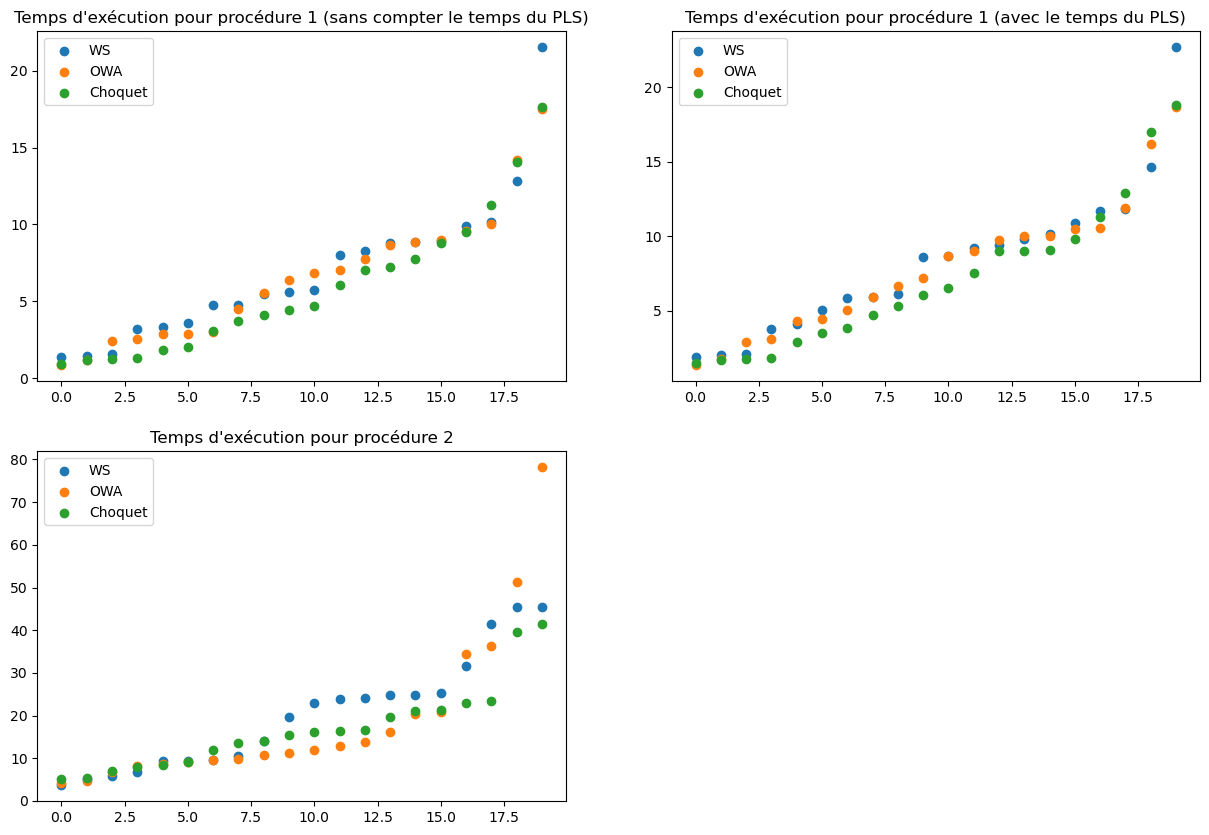

In [122]:
func_names = ["WS", "OWA", "Choquet"]
ind = 0
plt.figure(figsize=(15, 10))

for data in all_data_1:
    times = [d.tail(1)["Time since start"] for d in data]
    times = np.array(times).flatten()
    times_with_pls = times + time_pls #On ajoute le temps d'éxecution du PLS en plus du temps de l'élicitation incrémentale
    times = np.sort(times)
    times_with_pls = np.sort(times_with_pls)
    
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(times)), times, label=func_names[ind])
    plt.legend(loc='upper left')
    plt.title("Temps d'exécution pour procédure 1 (sans compter le temps du PLS)")
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(times_with_pls)), times_with_pls, label=func_names[ind])
    plt.title("Temps d'exécution pour procédure 1 (avec le temps du PLS)")
    plt.legend(loc='upper left')
    print("Temps d'éxecution (procédure 1 avec PLS) moyen pour " + func_names[ind] + " : " + str(np.mean(times_with_pls)) + ", médiane : " + str(np.median(times_with_pls)) + ", écart-type : " + str(np.std(times_with_pls)))
    ind += 1

ind = 0
for data in all_data_2:
    times = [d.tail(1)["Time"] for d in data]
    times = np.array(times).flatten()

    times = np.sort(times)

    plt.subplot(2, 2, 3)
    plt.scatter(range(len(times)), times, label=func_names[ind])
    plt.title("Temps d'exécution pour procédure 2")
    plt.legend(loc='upper left')
    print("Temps d'éxecution (procédure 2) moyen pour " + func_names[ind] + " : " + str(np.mean(times)) + ", médiane : " + str(np.median(times)) + ", écart-type : " + str(np.std(times)))
    ind += 1

### Comparaison en terme de l'erreur par rapport à la solution optimale du décideur

Temps d'éxecution (procédure 1 avec PLS) moyen pour WS : 2.2570332387671614, médiane : 2.1354633936153116, écart-type : 0.7031536155857739
Temps d'éxecution (procédure 1 avec PLS) moyen pour OWA : 2.2459007663190755, médiane : 2.1196702886907826, écart-type : 0.7112308450279305
Temps d'éxecution (procédure 2) moyen pour WS : 0.9754411835563852, médiane : 0.9753166663324605, écart-type : 0.019363248237171296
Temps d'éxecution (procédure 2) moyen pour OWA : 0.9303430145234051, médiane : 0.9450344153331884, écart-type : 0.034785488495816995


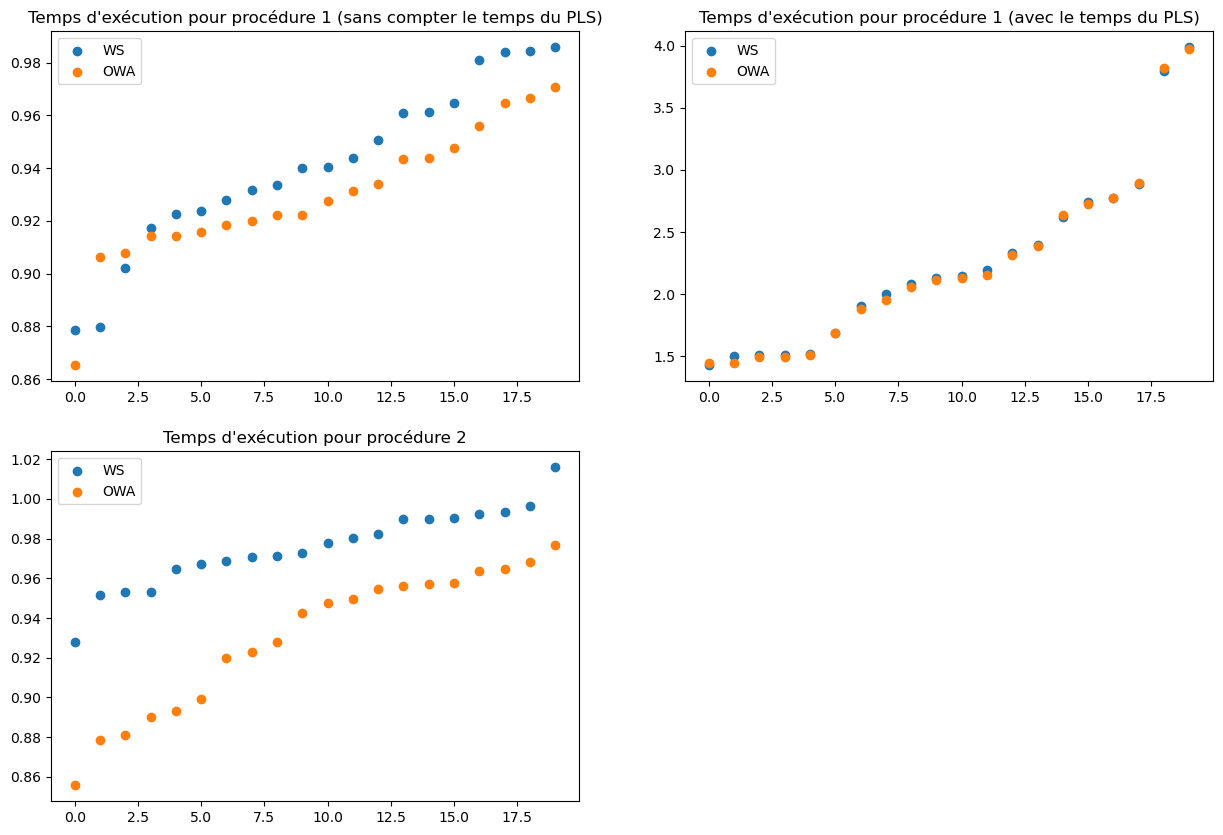

In [123]:
func_names = ["WS", "OWA", "Choquet"]
ind = 0
plt.figure(figsize=(15, 10))

#On ne prends pas en compte le dernier set de data qui correspond au Choquet, car nous n'avons pas implémenté le calcul de la solution optimale avec gurobi pour cette fonction
for data in all_data_1[:2]:
    times = [d.tail(1)["Error rate"] for d in data]
    times = np.array(times).flatten()
    times_with_pls = times + time_pls #On ajoute le temps d'éxecution du PLS en plus du temps de l'élicitation incrémentale
    times = np.sort(times)
    times_with_pls = np.sort(times_with_pls)
    
    plt.subplot(2, 2, 1)
    plt.scatter(range(len(times)), times, label=func_names[ind])
    plt.legend(loc='upper left')
    plt.title("Temps d'exécution pour procédure 1 (sans compter le temps du PLS)")
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(times_with_pls)), times_with_pls, label=func_names[ind])
    plt.title("Temps d'exécution pour procédure 1 (avec le temps du PLS)")
    plt.legend(loc='upper left')
    print("Temps d'éxecution (procédure 1 avec PLS) moyen pour " + func_names[ind] + " : " + str(np.mean(times_with_pls)) + ", médiane : " + str(np.median(times_with_pls)) + ", écart-type : " + str(np.std(times_with_pls)))
    ind += 1

ind = 0
for data in all_data_2[:2]:
    times = [d.tail(1)["Error rate"] for d in data]
    times = np.array(times).flatten()

    times = np.sort(times)

    plt.subplot(2, 2, 3)
    plt.scatter(range(len(times)), times, label=func_names[ind])
    plt.title("Temps d'exécution pour procédure 2")
    plt.legend(loc='upper left')
    print("Temps d'éxecution (procédure 2) moyen pour " + func_names[ind] + " : " + str(np.mean(times)) + ", médiane : " + str(np.median(times)) + ", écart-type : " + str(np.std(times)))
    ind += 1